In [31]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'detection-of-down-syndrome-in-children:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3469358%2F6062454%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240508%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240508T134255Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5d1b3e68d2819dc351130ba0ecfc92e2fb5ad65c06a003e9c721a2515ca576f4e35698372486d67a89e8e532b2cbd82476449a3e3ba80e4e24594b2386e777f4afe2f301a9d17e4eb962b49076fd4f8831978acb69b8cfe45fcaf56212b2c17b7f696595d2350887f83832a89732a7452d3a25357875201a16df715512489fa20beb493b59414d1defa89f4d674c2398eb79c86ca5da9e607f76aa1981c0e5182e8278469f1dd86bfad67701d351e60069fab963dbbee4564c0b925be7ece70f4ea1b76d660f8c7a8faf7a0d4e9261c1127529adbc6b04d421870b4f9ce212b40f7731ac1cdc2d381750ebaed7f806c4e802fa4a631abfcd0609cb6c00233df5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 31942914 bytes downloaded
Downloaded and uncompressed: detection-of-down-syndrome-in-children
Data source import complete.


In [32]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [33]:
# Importing dependencies

import os
import random
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8

In [34]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))

    return full_path


data_healthy = create_images_list('/kaggle/input/detection-of-down-syndrome-in-children/healty/healty')
data_down = create_images_list('/kaggle/input/detection-of-down-syndrome-in-children/downSyndorme/downSyndrome')


# look-up table
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [35]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):

    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]

    return img, label


def create_random_samples(data):

    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]

    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)

    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)


    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')

    plt.show()

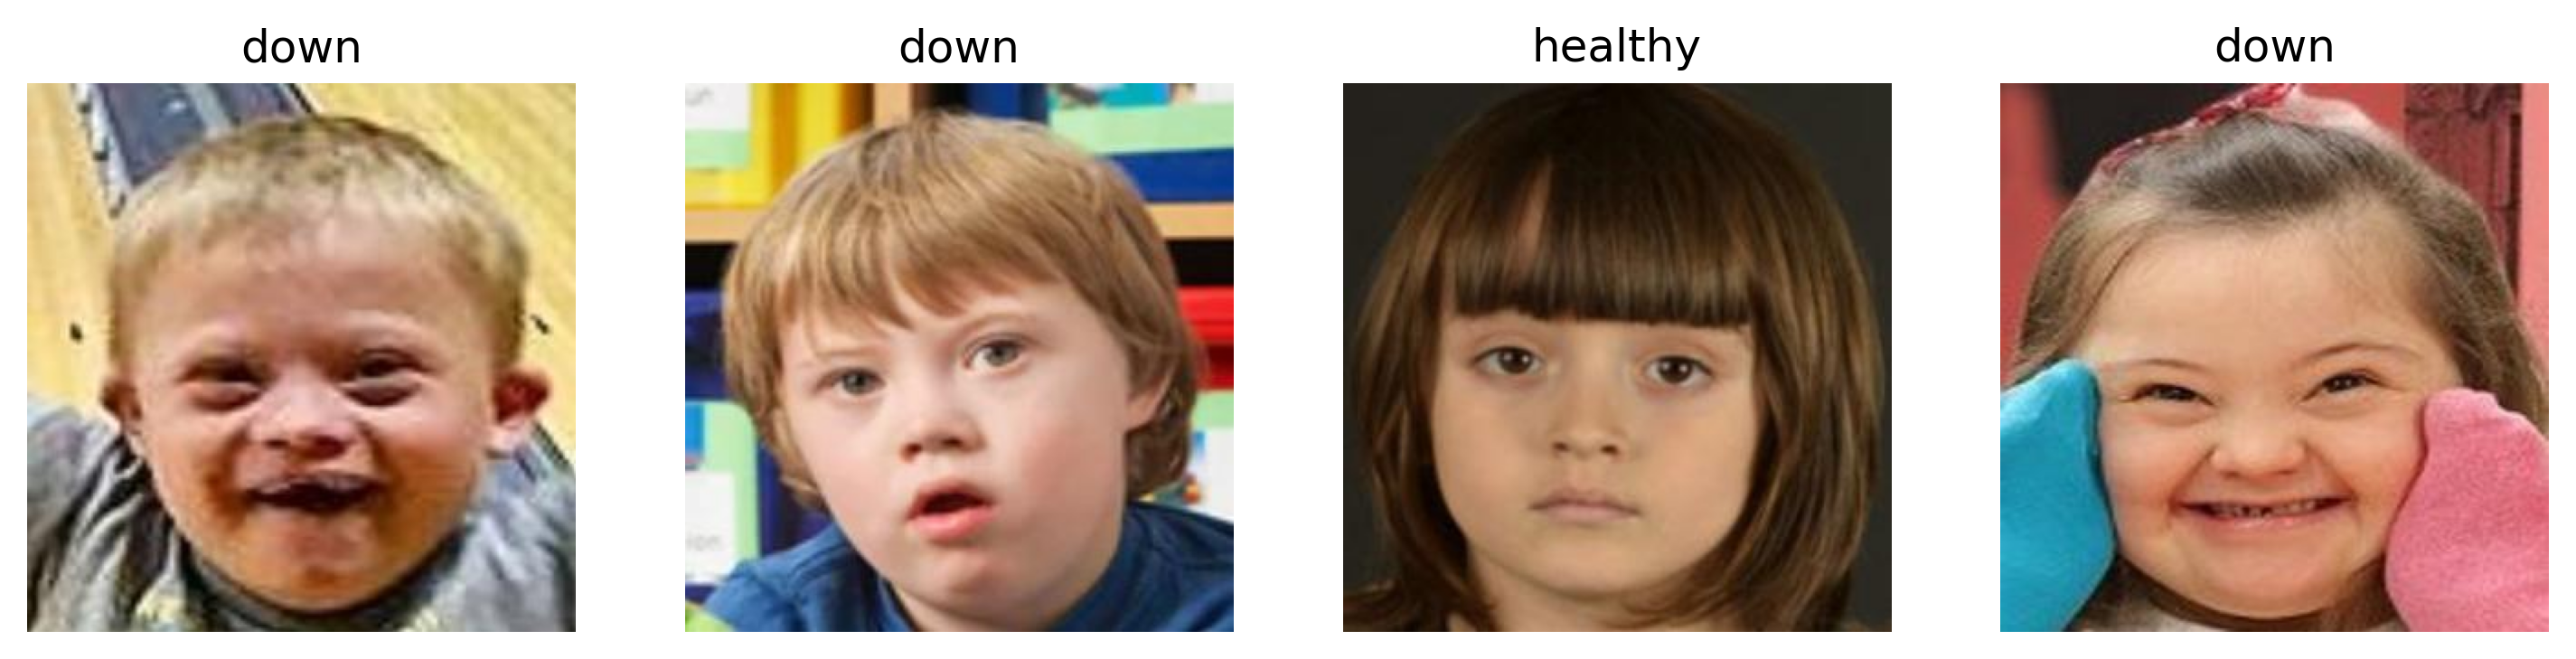

In [36]:
# Random samples

create_random_samples(data_df)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


# <span style="color:#e74c3c;"> Creating </span> Datasets


In [38]:
def img_preprocessing(image, label):

    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = img/255.0

    return img, label

In [39]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> CNN </span> Model


In [40]:
In = Input(shape=(250, 250, 3))

conv2 = Conv2D(32, 2, padding = 'same')(In)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(64, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(128, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


pool = GlobalAveragePooling2D()(conv2)
drop = Dropout(0.6)(pool)
dense1 = Dense(64, activation = 'relu')(drop)
dense1 = Dense(64, activation = 'relu')(dense1)
Out = Dense(1, activation = 'sigmoid')(dense1)

model = Model(inputs = In, outputs = Out)

model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 250, 250, 32)      416       
                                                                 
 batch_normalization_28 (Ba  (None, 250, 250, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_28 (Activation)  (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 125, 125, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 125, 125, 64)      8256

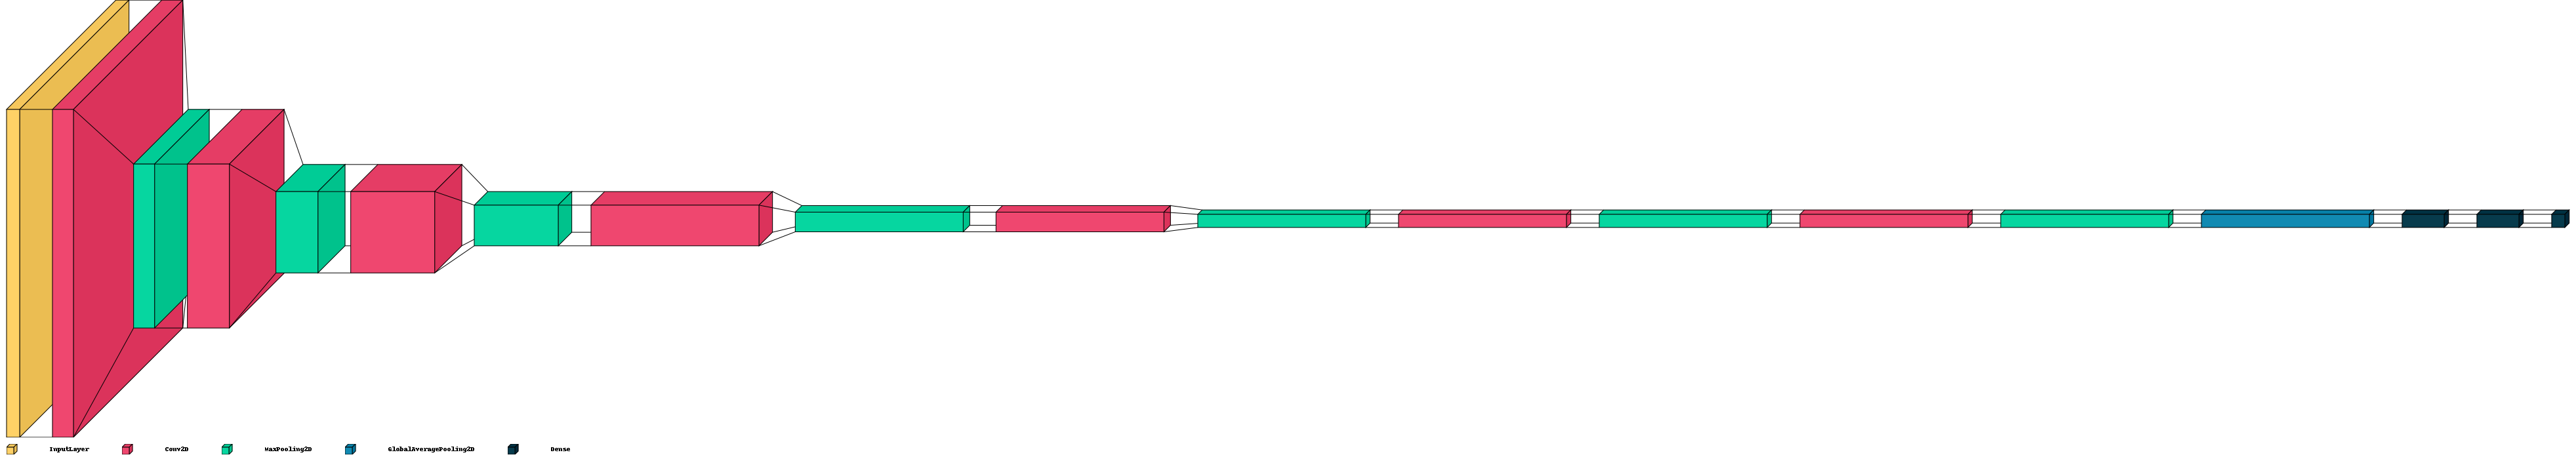

<Figure size 640x480 with 0 Axes>

In [41]:
#Plotting the model

plt.figure(dpi = 100)
visualkeras.layered_view(model, spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True, type_ignore=[BatchNormalization, Activation, Dropout])

# <span style="color:#e74c3c;"> Training </span>


In [42]:
# Training

my_callbacks = [EarlyStopping(monitor = 'loss', patience = 8, min_delta = 0.0001)]

hist = model.fit(train_dataset, epochs = 50, verbose =1, callbacks = my_callbacks)

Epoch 1/50
319/319 [==============================] - 17s 30ms/step - loss: 0.6551 - accuracy: 0.6371 - auc: 0.6887 - precision: 0.6395 - recall: 0.6499
Epoch 2/50
319/319 [==============================] - 12s 29ms/step - loss: 0.5617 - accuracy: 0.7136 - auc: 0.7820 - precision: 0.7089 - recall: 0.7374
Epoch 3/50
319/319 [==============================] - 11s 29ms/step - loss: 0.5205 - accuracy: 0.7375 - auc: 0.8201 - precision: 0.7331 - recall: 0.7576
Epoch 4/50
319/319 [==============================] - 11s 29ms/step - loss: 0.4482 - accuracy: 0.7897 - auc: 0.8705 - precision: 0.7858 - recall: 0.8040
Epoch 5/50
319/319 [==============================] - 11s 29ms/step - loss: 0.3960 - accuracy: 0.8242 - auc: 0.9020 - precision: 0.8143 - recall: 0.8459
Epoch 6/50
319/319 [==============================] - 11s 29ms/step - loss: 0.3627 - accuracy: 0.8490 - auc: 0.9180 - precision: 0.8463 - recall: 0.8575
Epoch 7/50
319/319 [==============================] - 12s 29ms/step - loss: 0.3160

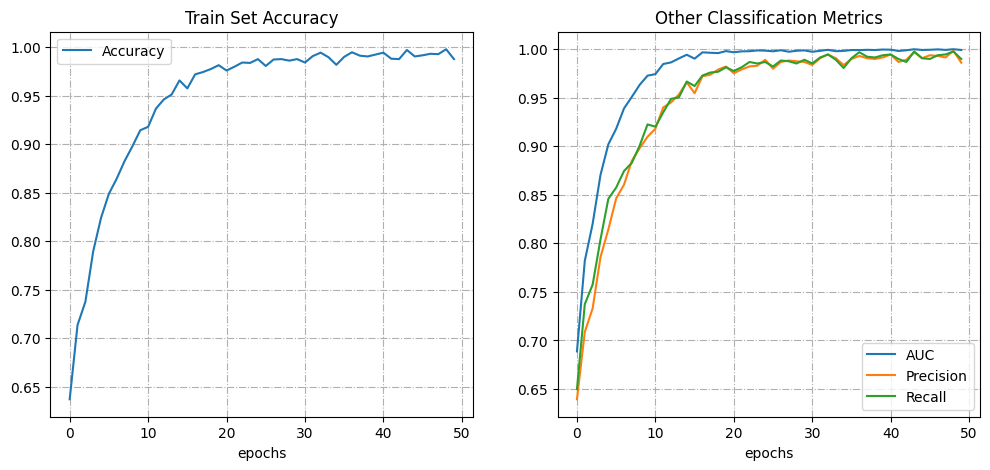

In [43]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Train Set Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].set_xlabel("epochs")
axs[0].legend(["Accuracy"])


axs[1].grid(linestyle="dashdot")
axs[1].set_title("Other Classification Metrics")
axs[1].plot(hist.history['auc'])
axs[1].plot(hist.history['precision'])
axs[1].plot(hist.history['recall'])
axs[1].set_xlabel("epochs")
axs[1].legend(["AUC", "Precision", "Recall"])


# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [44]:
# Test set evaluation

test_eval = model.evaluate(test_dataset)

print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))
print('test auc : {0:.3f}'.format(test_eval[2]))
print('test precision : {0:.3f}'.format(test_eval[3]))
print('test recall : {0:.3f}'.format(test_eval[4]))

57/57 [==============================] - 1s 13ms/step - loss: 0.7799 - accuracy: 0.8422 - auc: 0.9050 - precision: 0.8286 - recall: 0.8325
test accuracy : 84.222 %
test auc : 0.905
test precision : 0.829
test recall : 0.833


In [45]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

57/57 [==============================] - 1s 11ms/step


# <span style="color:#e74c3c;"> Confusion </span> Matrix


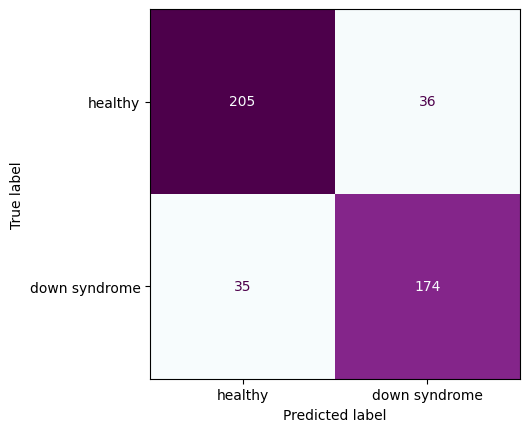

In [46]:
# Plotting the confusion matrix

cm = confusion_matrix(y_test_take, pred_)
cmd = ConfusionMatrixDisplay(cm, display_labels= ['healthy','down syndrome'])
cmd.plot(cmap = 'BuPu',colorbar = False )

# <span style="color:#e74c3c;"> Classification </span> Report


In [47]:
# Classification report

report = classification_report(np.array(y_test_take), pred_)
print(report)


              precision    recall  f1-score   support

           0       0.85      0.85      0.85       241
           1       0.83      0.83      0.83       209

    accuracy                           0.84       450
   macro avg       0.84      0.84      0.84       450
weighted avg       0.84      0.84      0.84       450



In [48]:
model.save("downsyndromemodel.h5")